In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

Usando o dispositivo: cuda


In [3]:
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
caminho_dados_treino =  'L:/final_project_ia377/data/train'
caminho_dados_validacao =  'L:/final_project_ia377/data/valid'

In [5]:
transforms_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

transforms_valid = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

Época 1/50 - Perda de Treino: 0.5731, Acurácia de Treino: 79.75%, Perda de Validação: 0.4756, Acurácia de Validação: 82.77%
Época 2/50 - Perda de Treino: 0.4511, Acurácia de Treino: 84.05%, Perda de Validação: 0.4572, Acurácia de Validação: 83.79%
Época 3/50 - Perda de Treino: 0.4215, Acurácia de Treino: 85.11%, Perda de Validação: 0.4702, Acurácia de Validação: 82.61%
Época 4/50 - Perda de Treino: 0.3998, Acurácia de Treino: 86.20%, Perda de Validação: 0.4574, Acurácia de Validação: 84.16%
Época 5/50 - Perda de Treino: 0.3821, Acurácia de Treino: 86.41%, Perda de Validação: 0.4825, Acurácia de Validação: 82.93%
Época 6/50 - Perda de Treino: 0.3665, Acurácia de Treino: 87.05%, Perda de Validação: 0.4399, Acurácia de Validação: 84.16%
Época 7/50 - Perda de Treino: 0.3540, Acurácia de Treino: 87.48%, Perda de Validação: 0.4334, Acurácia de Validação: 84.80%
Época 8/50 - Perda de Treino: 0.3397, Acurácia de Treino: 88.30%, Perda de Validação: 0.4574, Acurácia de Validação: 84.59%
Época 9/

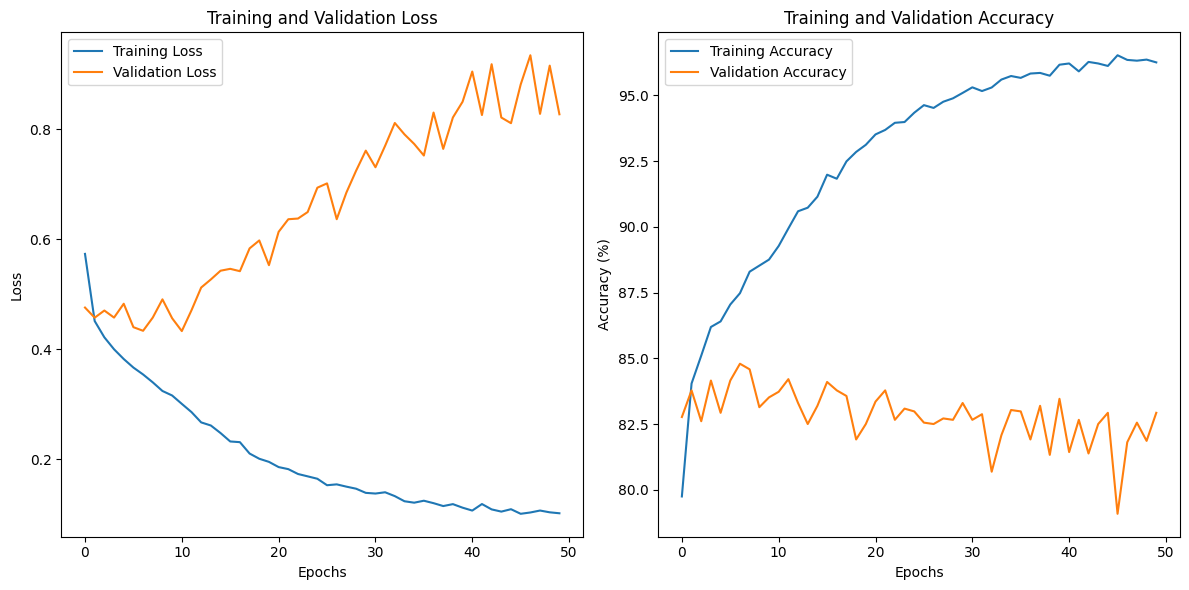

In [7]:
conjunto_dados_treino = ImageFolderWithPaths(root=caminho_dados_treino, transform=transforms_train)
conjunto_dados_validacao = ImageFolderWithPaths(root=caminho_dados_validacao, transform=transforms_valid)

carregador_treino = DataLoader(conjunto_dados_treino, batch_size=32, shuffle=True)
carregador_validacao = DataLoader(conjunto_dados_validacao, batch_size=32, shuffle=False)

model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(768, 5)
model = model.to(device)

learning_rate = 2e-05
weight_decay =  1e-4
batch_size = 16
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epocas = 50
melhor_auc = 0.0
melhor_modelo = None
perdas_treino = []
perdas_validacao = []
aucs_treino = []
aucs_validacao = []
criterio = nn.CrossEntropyLoss()


for epoca in range(num_epocas):
    model.train()
    perda_treino = 0.0
    correct_train = 0
    total_train = 0

    for entradas, rotulos, _ in carregador_treino:
        entradas, rotulos = entradas.to(device), rotulos.to(device)
        optimizer.zero_grad()
        saidas = model(entradas)
        perda = criterio(saidas, rotulos)
        perda.backward()
        optimizer.step()

        perda_treino += perda.item()
        _, predicted = torch.max(saidas.data, 1)
        total_train += rotulos.size(0)
        correct_train += (predicted == rotulos).sum().item()

    acc_treino = 100 * correct_train / total_train
    perdas_treino.append(perda_treino / len(carregador_treino))
    aucs_treino.append(acc_treino)  

    # Validação
    model.eval()
    perda_validacao = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for entradas, rotulos, _ in carregador_validacao:
            entradas, rotulos = entradas.to(device), rotulos.to(device)
            saidas = model(entradas)
            perda = criterio(saidas, rotulos)

            perda_validacao += perda.item()
            _, predicted = torch.max(saidas.data, 1)
            total_val += rotulos.size(0)
            correct_val += (predicted == rotulos).sum().item()

    acc_validacao = 100 * correct_val / total_val
    perdas_validacao.append(perda_validacao / len(carregador_validacao))
    aucs_validacao.append(acc_validacao) 
    print(f'Época {epoca+1}/{num_epocas} - Perda de Treino: {perdas_treino[-1]:.4f}, Acurácia de Treino: {acc_treino:.2f}%, Perda de Validação: {perdas_validacao[-1]:.4f}, Acurácia de Validação: {acc_validacao:.2f}%')

   
    if acc_validacao > melhor_auc:
        melhor_auc = acc_validacao
        melhor_modelo = model
        torch.save(melhor_modelo.state_dict(), 'L:/final_project_ia377/model/vit_baseline.pth')



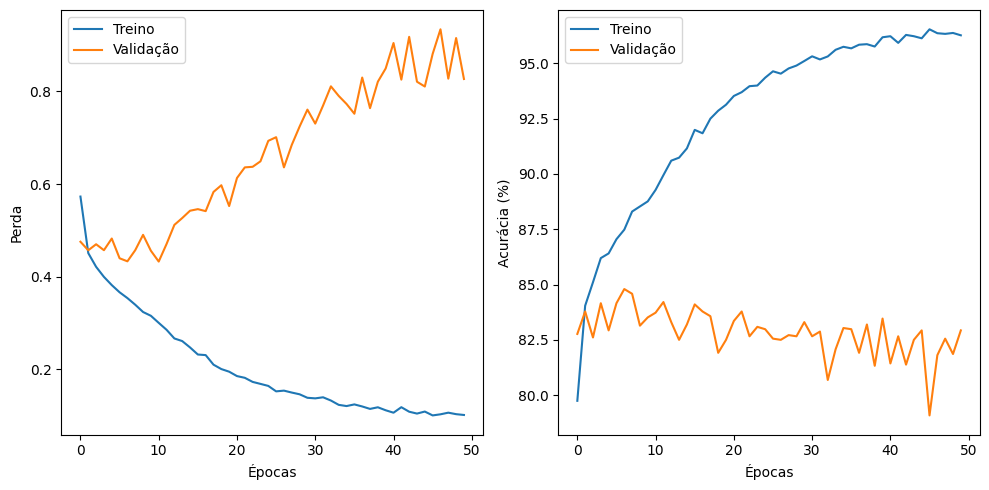

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(perdas_treino, label='Treino')
plt.plot(perdas_validacao, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(aucs_treino, label='Treino') 
plt.plot(aucs_validacao, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
melhor_modelo.eval()  

all_predictions = []
all_labels = []

with torch.no_grad():
    for entradas, rotulos, _ in carregador_validacao:
        entradas, rotulos = entradas.to(device), rotulos.to(device)
        saidas = melhor_modelo(entradas)
        _, predicted = torch.max(saidas.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(rotulos.cpu().numpy())


confusion_mat = confusion_matrix(all_labels, all_predictions)

class_names = [str(i) for i in range(5)] 

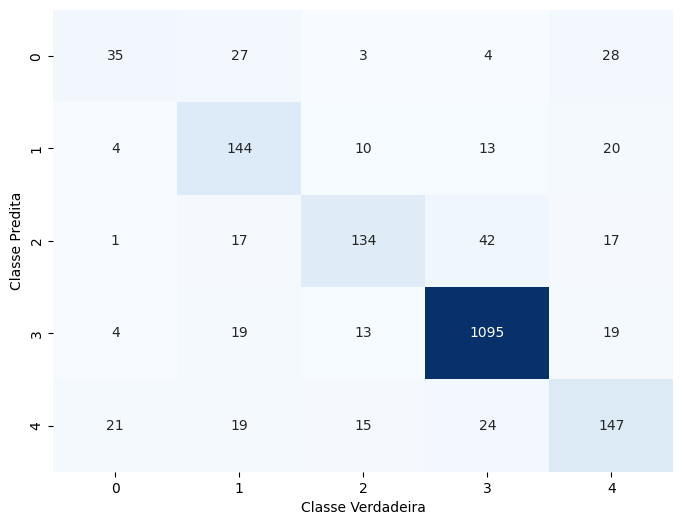

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Predita")
plt.show()

In [36]:

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

caminho_dados_teste = 'L:/final_project_ia377/data/test'
conjunto_dados_teste = ImageFolder(root=caminho_dados_teste, transform=transforms_test)
carregador_teste = DataLoader(conjunto_dados_teste, batch_size=16, shuffle=False)
melhor_modelo.eval() 
all_predictions_teste = []
class_names = conjunto_dados_teste.classes

with torch.no_grad():
    for entradas, _ in carregador_teste:
        entradas = entradas.to(device)
        saidas = melhor_modelo(entradas)
        _, predicted = torch.max(saidas.data, 1)
        all_predictions_teste.extend(predicted.cpu().numpy())


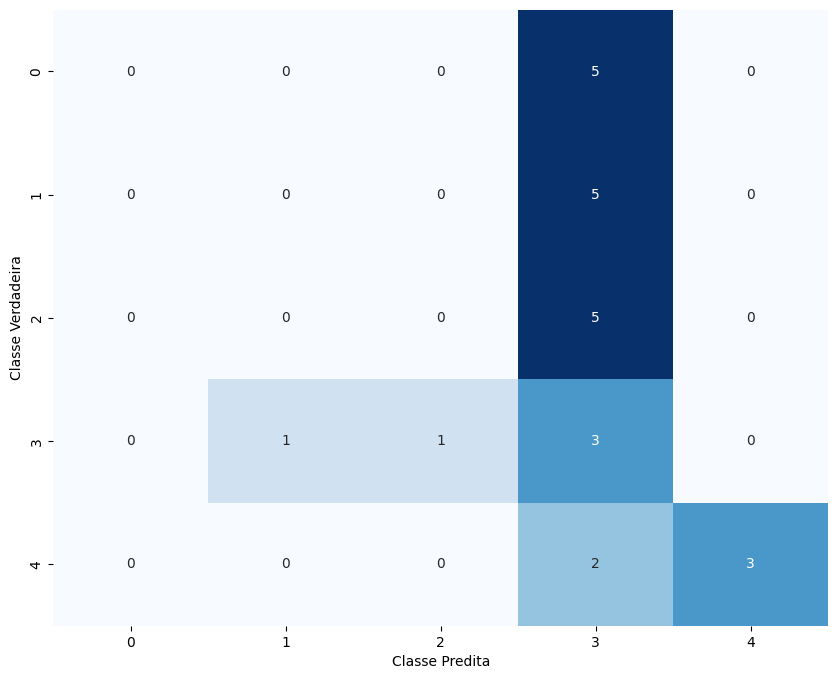

In [42]:
def map_labels_to_class_names(label_indices, class_names):
    return [class_names[i] for i in label_indices]

y_true = map_labels_to_class_names(conjunto_dados_teste.targets, class_names)
y_pred = map_labels_to_class_names(all_predictions_teste, class_names)

confusion_mat = confusion_matrix(y_true, y_pred, labels=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()